-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y


# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "BCR"  # "GMV"か"BCR"
TRAIN_SIZE = 100000
TEST_SIZE = 100000
THRESHOLD_LIST = [2]  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

-----------
### データの前処理

In [ ]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
df_train = df_all.iloc[:TRAIN_SIZE]
df_test = df_all.iloc[TRAIN_SIZE : TRAIN_SIZE + TEST_SIZE]

In [4]:
df_train = df_train.copy()
df_train["BCR"] = np.where(df_train["GMV"] > 0, 1, 0)
df_test = df_test.copy()
df_test["BCR"] = np.where(df_test["GMV"] > 0, 1, 0)

-------------
### 外れ値を除外しない場合（訓練データ）

0のデータ数： 57348


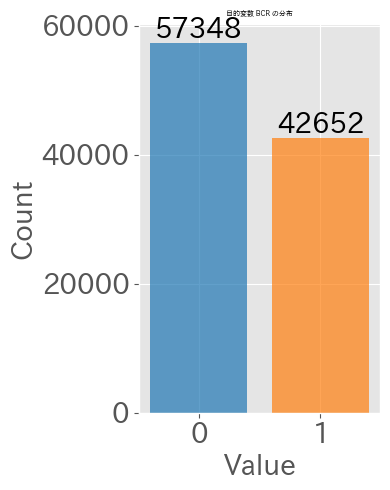

In [5]:
y = df_train[TARGET]
print("0のデータ数：", len(y[y == 0]))

if TARGET == "GMV":
    # 0のデータと0以外のデータを区別して可視化
    fig, axes = plt.subplots(1, 1, figsize=(12, 5))

    # 0以外のデータのヒストグラム
    axes.hist(
        y[y > 0],
        bins=30,
        color="#1f77b4",
        alpha=0.7,
    )
    axes.set_title("GMVが0より大きいデータの分布", fontsize=30)
    axes.set_xlabel("Value", fontsize=20)
    axes.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()


if TARGET == "BCR":
    counts = y.value_counts()
    labels = counts.index  # [0, 1]
    values = counts.values  # [count_0, count_1]

    # プロット
    fig, ax = plt.subplots(figsize=(4, 5))
    bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

    # 各バーの上に数値を表示
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # バーの中央
            bar.get_height(),  # バーの高さ
            f"{value}",  # 表示する数値
            ha="center",
            va="bottom",
            fontsize=20,
        )

    # ラベルとタイトルを設定
    ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
    ax.set_xlabel("Value", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
    ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
    ax.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()

-------------
### 外れ値除外（訓練データ）

In [6]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

閾値：2
外れ値除外前のデータ数（訓練+テスト）: 100000
外れ値除外後のデータ数（訓練+テスト）: 100000
除外されたデータ数： 0
0のデータ数： 57348
分散： 0.24460068960000003


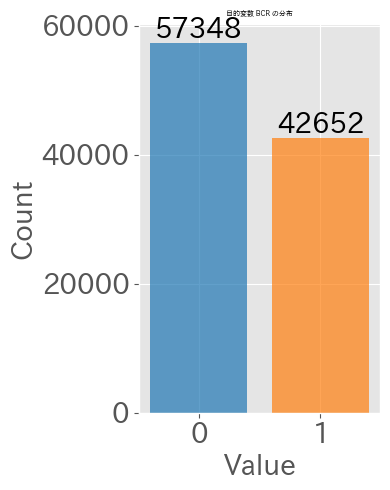

In [7]:
for i in range(len(THRESHOLD_LIST)):
    df_outliers_removed = remove_outliers_zscore(
        data=df_train, metric=TARGET, threshold=THRESHOLD_LIST[i]
    )
    df_outliers_removed = df_outliers_removed.reset_index(drop=True)  # 行を詰める
    y = df_outliers_removed[TARGET]
    print(f"閾値：{THRESHOLD_LIST[i]}")
    print("外れ値除外前のデータ数（訓練）:", TRAIN_SIZE)
    print("外れ値除外後のデータ数（訓練）:", len(df_outliers_removed))
    print("除外されたデータ数：", TRAIN_SIZE - len(df_outliers_removed))
    print("0のデータ数：", len(y[y == 0]))
    print("分散：", np.var(y))

    if TARGET == "GMV":
        # 0のデータと0以外のデータを区別して可視化
        fig, axes = plt.subplots(1, 1, figsize=(12, 5))

        # 0以外のデータのヒストグラム
        axes.hist(
            y[y > 0],
            bins=30,
            color="#1f77b4",
            alpha=0.7,
        )
        axes.set_title(
            f"GMVが0より大きいデータの分布 (閾値＝{THRESHOLD_LIST[i]})", fontsize=30
        )
        axes.set_xlabel("Value", fontsize=20)
        axes.tick_params(axis="both", labelsize=20)

        plt.tight_layout()
        plt.show()

    if TARGET == "BCR":
        counts = y.value_counts()
        labels = counts.index  # [0, 1]
        values = counts.values  # [count_0, count_1]

        # プロット
        fig, ax = plt.subplots(figsize=(4, 5))
        bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

        # 各バーの上に数値を表示
        for bar, value in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # バーの中央
                bar.get_height(),  # バーの高さ
                f"{value}",  # 表示する数値
                ha="center",
                va="bottom",
                fontsize=20,
            )

        # ラベルとタイトルを設定
        ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
        ax.set_xlabel("Value", fontsize=20)
        ax.set_ylabel("Count", fontsize=20)
        ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
        ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
        ax.tick_params(axis="both", labelsize=20)

        plt.tight_layout()
        plt.show()